In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Barrier method

For implementation of log-barrier method, we consider the following problem:

$$\min_{v} t(v^t Q v + p^t v) + \phi$$ 
with $\phi = -\sum_{i=1}^d \log(-Av+b)(i)$.

This problem is shown in the `readme.md` to derive from LASSO problem. 

For the centering step of the Newton method, we compute the gradient and the Hessian matrix corresponding to the last problem:
$$\nabla f(v) = t(2Qv+p) + \sum_{i=1}^d \frac{A(i)}{(-Av+b)(i)} $$ 
$$ \nabla^2 f(v) = 2tQ^t + \sum_{i=1}^d \frac{1}{(-Av+b)(i)^2}A(i)A(i)^t$$

In [2]:
alpha, beta = 0.1, 0.7
mu = 5
n, d = 20, 15 
eps = 10e-6
lamb = 10

def f(Q, A, b, v, t0):
    return t0*(np.dot(np.dot(v.T, Q), v) + np.dot(p.T, v)) - sum([np.log(-np.dot(A[i], v) + b[i]) for i in range (b.shape[0])])

def line_search(Q, p, v, t, grad_f, newton_step, t0):
    if (-A.dot(v + t*newton_step) + b>0).all() and f(Q, A, b, v + t*newton_step, t0) <= (f(Q, A, b, v, t0) + alpha*t*np.dot(grad_f.T, newton_step)):
        return v + t*newton_step
    else: 
        return line_search(Q, p, v, beta*t, grad_f, newton_step, t0)

def centering_step(Q, p, A, b, t, v0, eps=10e-6, n_it_centering=0):
    V = []
    d, n = np.shape(A)
        
    C = -np.dot(A, v0)+b
    B = np.array([[A[i,k]/C[i] for k in range(n)] for i in range(d)])
    grad_f = t*(2*np.dot(Q, v0)+p) + np.sum(B, axis=0)
           
    B1 = [np.dot(A[i,:], np.matrix.transpose(A[i,:]))/(C[i]**2) for i in range(d)]
    hess_f = t*2*np.matrix.transpose(Q) + np.sum(B1)
        
    newton_step = -np.dot(np.linalg.inv(hess_f), grad_f)
    decrement2 = np.dot(grad_f.T, np.dot(np.linalg.inv(hess_f), grad_f))
    
    # stopping criterion
    if decrement2/2 <= eps:
        return v0, n_it_centering
    
    v1 = line_search(Q, p, v0, 1, grad_f, newton_step, t)
    return centering_step(Q, p, A, b, t, v1, eps, n_it_centering+1)

def barr_method(Q, p, A, b, v0, eps=10e-6, mu=5):
    t = 1
    v = v0
    d, n = np.shape(A)
    n_it, v_seq, n_it_value = [0], [v0], 0
    
    for _ in range(1000): # max it allowed
        # centering step
        v, n_it_centering = centering_step(Q, p, A, b, t, v, eps)
        n_it_value += n_it_centering
        n_it.append(n_it_value)
        v_seq.append(v)
        
        # stopping criterion
        if d/t < eps:
            return v, n_it, v_seq
        
        t = mu*t
    return v, n_it, v_seq

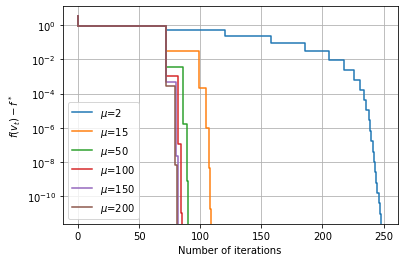

In [12]:
X = np.random.rand(n,d)
y = np.random.rand(n,1)

Q = 0.5*np.eye(n)
p = -y
A = np.vstack((X.T,-X.T))
b = lamb*np.ones((2*d,1))

v0 = np.zeros((n,1))

plt.figure()
mu_list = [2, 15, 50, 100, 150, 200]
for mu in mu_list:
    v_center, n_it_seq, v_seq = barr_method(Q, p, A, b, v0, eps=10e-6, mu=mu)
    f_found = [float((np.dot(v.T, np.dot(Q, v)) + np.dot(p.T, v))[0]) for v in v_seq]
    plt.step(n_it_seq, np.array(f_found) - f_found[-1], label=fr"$\mu$={str(mu)}")
plt.legend()
plt.ylabel(r"$f(v_t) - f^*$")
plt.xlabel("Number of iterations")
plt.semilogy()
plt.grid()
plt.show()

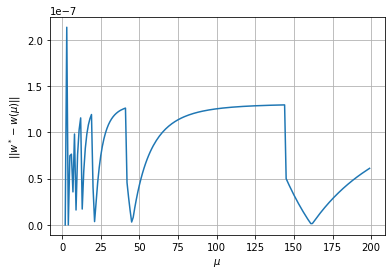

In [19]:
from scipy.linalg import lstsq

mu_list, w_list = np.arange(2, 200, 1), []
for mu in mu_list:
    v_center, n_it_seq, v_seq = barr_method(Q, p, A, b, v0, eps=10e-6, mu=mu)
    w = lstsq(X,-v_center-y)[0]
    w_list.append(w)
    
f_w = [float((1/2)*np.linalg.norm(np.dot(X, w)-y, 2) + lamb*np.linalg.norm(w, 1))]
diff_w = [np.linalg.norm(w - w_list[np.argmin(f_w)]) for w in w_list]

plt.figure()
plt.plot(mu_list, diff_w)
plt.ylabel(r"$||w^* - w(\mu)||$")
plt.xlabel(r"$\mu$")
plt.grid()
plt.show()

On observe des valeurs assez chaotiques pour $\mu<25$, donc on peut restreindre les valeurs de $\mu$ d'intérêt à $[25, 200]$. D'autre part, sur certaines plages de valeurs, la différence $||w^* - w(\mu)||$ augmente. Il faudrait donc se placer à un creux, par exemple pour $\mu \approx 45$. Pour cette valeur de $\mu$ la convergence est presque aussi rapide que pour des valeurs plus élevées, comme on peut le voir sur le premier graphe. 